# Australia - Antarctica spreading rates

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pygplates
import numpy as np
import csv

from velocities_by_plate_id import calculate_velocities
from velocities_by_plate_id import calculate_velocities_along_reconstructed_geometry
from velocities_by_plate_id import calculate_velocities_over_time

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [2]:
rotation_filename = 'SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
static_polygons = 'SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz'
reconstruction_feature = 'SampleData/FeatureCollections/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz'

australia_plateID = 801
antarctica_plateID = 802

In [3]:
reconstruction_time = 30 # Ma

reconstructed_shapefile = "reconstruction_{:3.0f}.shp"

pygplates.reconstruct(reconstruction_feature, \
                      rotation_filename, \
                      reconstructed_shapefile.format(reconstruction_time), \
                      reconstruction_time, \
                      anchor_plate_id=antarctica_plateID)



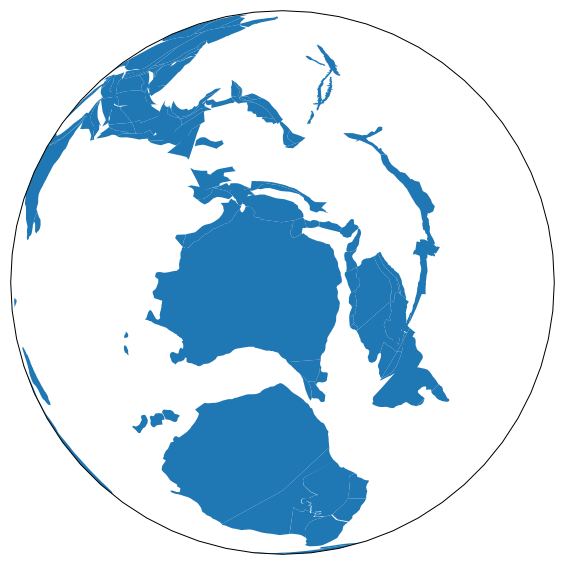

In [4]:
# proj = ccrs.NearsidePerspective(140, -40, satellite_height=4e6)
proj = ccrs.Orthographic(140,-40)
# proj = ccrs.AzimuthalEquidistant(140, -40, )

shp = shpreader.Reader(reconstructed_shapefile.format(reconstruction_time)).geometries()
ft  = cfeature.ShapelyFeature(shp, ccrs.PlateCarree())


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=proj)
ax.add_feature(ft)

In [5]:
points_downunder = np.array([[145.0, -38.0], # Victoria
                             [133.0, -23.0], # central Australia
                             [122.0, -16.0]])

npts = points_downunder.shape[0]

# create point features
point_features = []
for lon, lat in points_downunder:
    point_feature = pygplates.Feature()
    point_feature.set_geometry(pygplates.PointOnSphere(lat, lon))
    point_features.append(point_feature)

# lookup plate ID
partitioned_point_features = pygplates.partition_into_plates(static_polygons,
                                                            rotation_filename,
                                                            point_features)

# print out plateID for each point feature
# they should all be 801 for Australia
for pfeature in partitioned_point_features:
    print("{:3}".format(pfeature.get_reconstruction_plate_id()))

801
801
801


In [6]:
# Reconstruct!

reconstruction_times = np.arange(0, 100, 1) # Ma

lons_out = np.empty((reconstruction_times.size, npts))
lats_out = np.empty((reconstruction_times.size, npts))
vels_out = np.empty((reconstruction_times.size, npts))

for t, reconstruction_time in enumerate(reconstruction_times):
    out_data = calculate_velocities(rotation_filename,
                                    partitioned_point_features,
                                    1.0,
                                    reconstruction_time,
                                    anchor_plate_id=antarctica_plateID)
    
    tlon, tlat, vel, ovel, arc, oarc, plateID = np.array(out_data).T
    
    lons_out[t] = tlon
    lats_out[t] = tlat
    vels_out[t] = vel

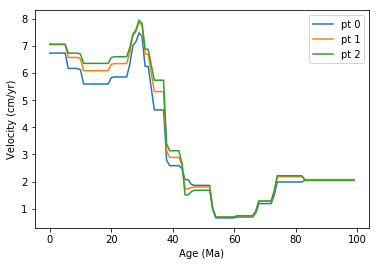

In [7]:

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Velocity (cm/yr)')

for pt in range(npts):
    ax.plot(reconstruction_times, vels_out[:,pt], label="pt {}".format(pt))
    
ax.legend()